In [1]:
!python -m pip install -q lightning --no-cache-dir
!pip install -q grad-cam
!pip install -q global_land_mask

In [2]:
from huggingface_hub import snapshot_download
snapshot_download(repo_id="osv5m/osv5m", local_dir="datasets/osv5m", allow_patterns=[
    'images/train/00.zip',
    'images/test/00.zip',
    '*.csv'
    ], repo_type='dataset')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

00.zip:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

00.zip:   0%|          | 0.00/2.25G [00:00<?, ?B/s]

'/content/datasets/osv5m'

In [3]:
import csv
import numpy as np
import pandas as pd
from shapely.geometry import Point

import geopandas as gpd
from geopandas import GeoDataFrame

import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import zipfile
from time import sleep

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchvision import datasets, transforms

from PIL import Image
import pandas as pd

from tqdm.notebook import trange, tqdm

from global_land_mask import globe

In [4]:
for root, dirs, files in os.walk("datasets/osv5m"):
    for file in files:
        if file.endswith(".zip"):
            with zipfile.ZipFile(os.path.join(root, file), 'r') as zip_ref:
                for member in tqdm(zip_ref.infolist(), desc=f'Extracting {file}'):
                  zip_ref.extract(member, root)
            os.remove(os.path.join(root, file))

Extracting 00.zip:   0%|          | 0/50001 [00:00<?, ?it/s]

Extracting 00.zip:   0%|          | 0/50001 [00:00<?, ?it/s]

In [5]:
MAX_FILES = 10000

class ImageCoordinateDataset(Dataset):
    def __init__(self, csv_file, image_dirs, train: bool, transform=None):
        self.data = []
        self.skipped = []
        self.files = []
        for image_dir in image_dirs:
          self.files.extend([f"{image_dir}/{f}" for f in listdir(image_dir) if isfile(join(image_dir, f))])
        self.csv = 'datasets/osv5m/train.csv' if train else 'datasets/osv5m/test.csv'

        print('Reading', self.csv)
        df = pd.read_csv(self.csv, usecols=range(3))
        row_count, column_count = df.shape

        # for full_path in tqdm(self.files, total=len(self.files), desc='Processing files'):
        for full_path in tqdm(self.files[:MAX_FILES], total=MAX_FILES, desc='Processing files'):
            image_name = str(Path(full_path).stem)

            row = df[df['id'] == int(image_name)].iloc[0]

            lat = row['latitude']
            lon = row['longitude']

            # Remove mislaballed images (ocean pictures?)
            if not globe.is_land(float(lat), float(lon)):
              self.skipped.append(image_name)
              continue
            self.data.append(np.array([str(full_path), float(lat), float(lon)]))

        self.transform = transform
        print(f'Dataset ready, {len(self.data)} files.')
        print(f'Skipped {len(self.skipped)} non-land files.')


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx][0]
        image = Image.open(img_path).convert('RGB')
        coordinates = (float(self.data[idx][1]), float(self.data[idx][2]))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(coordinates, dtype=torch.float32)


In [6]:
# https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/
# The mean and std of ImageNet are: mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
normalize = transforms.Normalize(mean.tolist(), std.tolist())

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [7]:
train_dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/train.csv', image_dirs=[
                                      '/content/datasets/osv5m/images/train/00',
                                      ],\
                                 train=True,
                                 transform=transform)
val_dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/train.csv', image_dirs=[
                                      '/content/datasets/osv5m/images/test/00',
                                      ],\
                                 train=False,
                                 transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Reading datasets/osv5m/train.csv


Processing files:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset ready, 9883 files.
Skipped 117 non-land files.
Reading datasets/osv5m/test.csv


Processing files:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset ready, 9847 files.
Skipped 153 non-land files.


In [8]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('using cuda')
else:
  device = torch.device("cpu")
  print('using cpu')
torch.cuda.empty_cache()

using cuda


In [10]:
class GeoLocationModel(nn.Module):
    def __init__(self):
        super(GeoLocationModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = GeoLocationModel().to(device)

In [11]:
# https://github.com/gastruc/osv5m/blob/main/models/losses.py
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, x, y):
        """
        Args:
            x: torch.Tensor Bx2
            y: torch.Tensor Bx2
        Returns:
            torch.Tensor: Haversine loss between x and y: torch.Tensor([B])
        Note:
            Haversine distance doesn't contain the 2 * 6371 constant.
        """
        lhs = torch.sin((x[:, 0] - y[:, 0]) / 2) ** 2
        rhs = (
            torch.cos(x[:, 0])
            * torch.cos(y[:, 0])
            * torch.sin((x[:, 1] - y[:, 1]) / 2) ** 2
        )
        a = lhs + rhs
        return torch.arctan2(torch.sqrt(a), torch.sqrt(1 - a))

In [12]:
from torch.optim.lr_scheduler import ExponentialLR

haversineLoss = HaversineLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [13]:
num_epochs = 5
avg_epoch_loss = []

for epoch in tqdm(range(num_epochs), total=num_epochs, desc='Epochs'):
  train_loss = []
  avg_loss = 0

  for images, coordinates in tqdm(train_dataloader, total=len(train_dataloader), desc=f'Epoch {epoch + 1} progress'):

    images, coordinates = images.cuda(), coordinates.cuda()

    optimizer.zero_grad()

    outputs = model(images)

    loss_haversine = haversineLoss(outputs, coordinates).mean(dim=-1)

    train_loss.append(loss_haversine.detach())

    loss_haversine.backward()

    optimizer.step()

  scheduler.step()
  avg_loss = sum(train_loss) / len(train_dataloader)
  avg_epoch_loss.append(avg_loss)
  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 progress:   0%|          | 0/309 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.7880


Epoch 2 progress:   0%|          | 0/309 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.7931


Epoch 3 progress:   0%|          | 0/309 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.7867


Epoch 4 progress:   0%|          | 0/309 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.7776


Epoch 5 progress:   0%|          | 0/309 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.7784


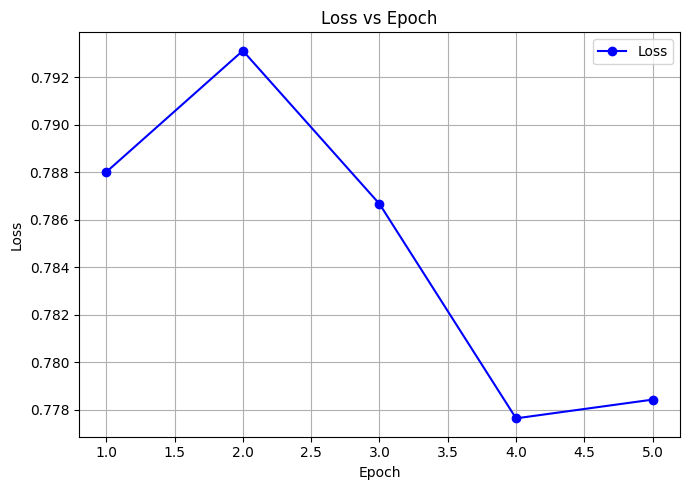

In [14]:
import matplotlib.pyplot as plt
avg_epoch_loss = torch.tensor(avg_epoch_loss, device =  'cpu')
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(avg_epoch_loss) + 1), avg_epoch_loss, label='Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
model.eval()

GeoLocationModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [17]:
avg_val_haversine_loss = 0.0
batch_haversine = []

with torch.no_grad():  # Disable gradient calculation for validation
    for images, coordinates in tqdm(val_dataloader, total=len(val_dataloader), desc=f'Validating'):
        # Forward pass
        images, coordinates = images.cuda(), coordinates.cuda()
        outputs = model(images)

        loss_haversine = haversineLoss(outputs, coordinates).mean(dim=-1)
        batch_haversine.append(loss_haversine)
        avg_val_haversine_loss += loss_haversine

# Calculate average loss and haversine
avg_val_haversine_loss /= len(val_dataloader)

print(f'Validation Haversine Loss: {avg_val_haversine_loss:.4f}')

Validating:   0%|          | 0/308 [00:00<?, ?it/s]

Validation Haversine Loss: 0.7855


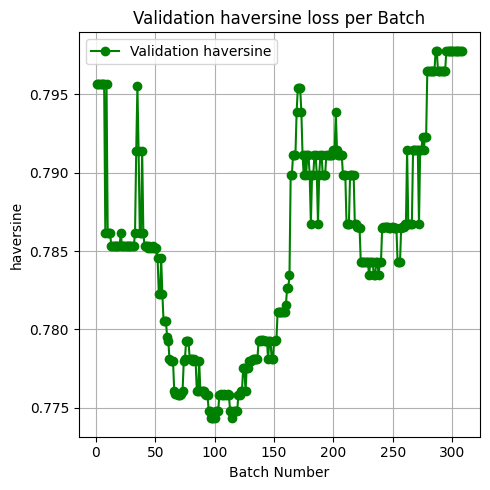

In [18]:
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

# Back from gpu
batch_haversine = torch.tensor(batch_haversine, device =  'cpu')

# Remove outliers
batch_haversine = median_filter(batch_haversine, size=100)

plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.plot(range(1, len(batch_haversine) + 1), batch_haversine, label='Validation haversine', color='green', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('haversine')
plt.title('Validation haversine loss per Batch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
# Step 5: Visualize some predictions (optional)
import matplotlib.pyplot as plt
import random

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def plot_predictions(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for images, coordinates in dataloader:

            images = images.cuda()

            outputs = model(images)

            images = images.cpu()
            outputs = outputs.cpu()

            rand_index = random.sample(range(0, len(images) - 1), min(num_samples, len(images)))

            for i in range(min(num_samples, len(images))):
                i = rand_index[i]

                pred_lat, pred_lon = outputs[i].cpu().numpy()
                true_lat, true_lon = coordinates[i].numpy()

                haver_err = haversineLoss(
                                      torch.tensor(np.array([[pred_lon, pred_lat]]), dtype=torch.float32).deg2rad(),
                                      torch.tensor(np.array([[true_lon, true_lat]]), dtype=torch.float32).deg2rad(),
                                      )
                # Display the image
                img = images[i]
                img = unnormalize(img).permute(1, 2, 0).numpy()
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f'Pred: ({pred_lat:.4f}, {pred_lon:.4f})\nTrue: ({true_lat:.4f}, {true_lon:.4f})\n Haversine: {haver_err}')
                plt.axis('off')

                # World map for better understanding of how bad our prediction is
                geometry = [Point(pred_lon, pred_lat), Point(true_lon, true_lat)]
                geo_df = GeoDataFrame(geometry = geometry)
                world = gpd.read_file(url)
                geo_df.plot(ax=world.plot(color="lightgrey", figsize=(10, 6)), marker='x', c=['red', 'green'], markersize=50);

                plt.show()
            break

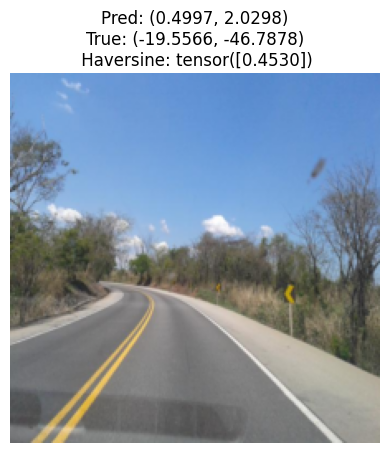

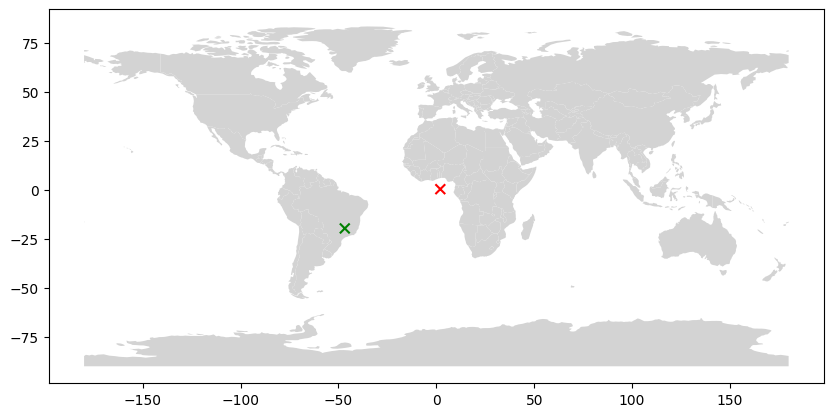

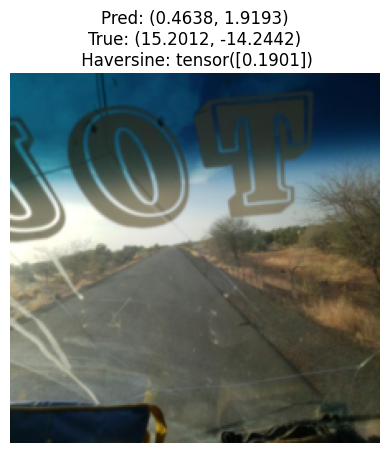

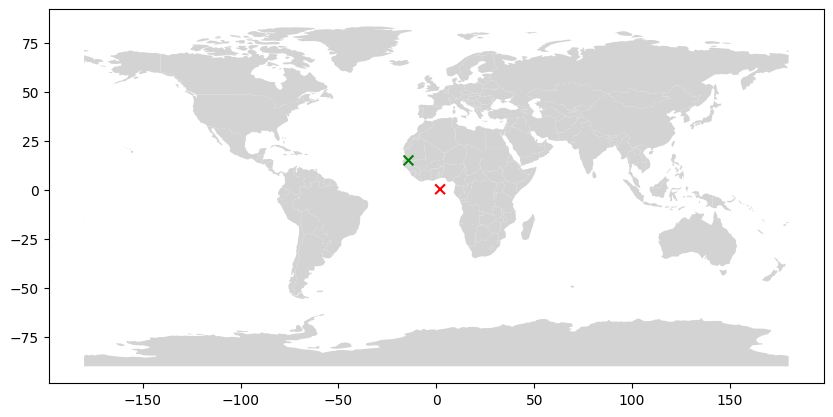

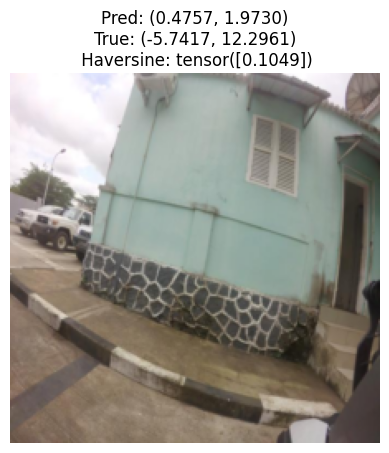

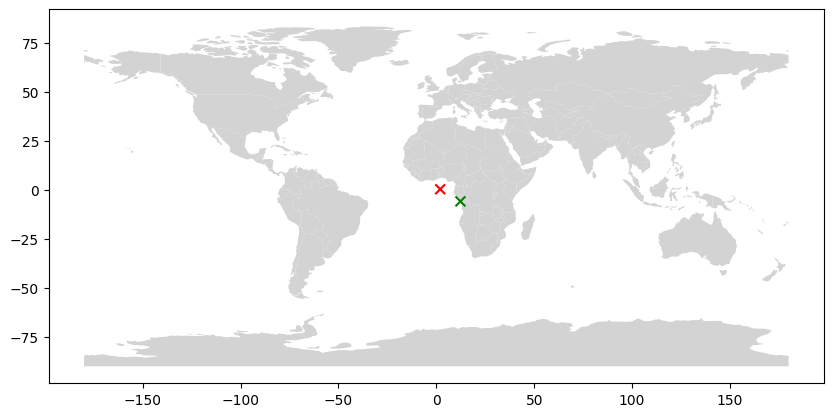

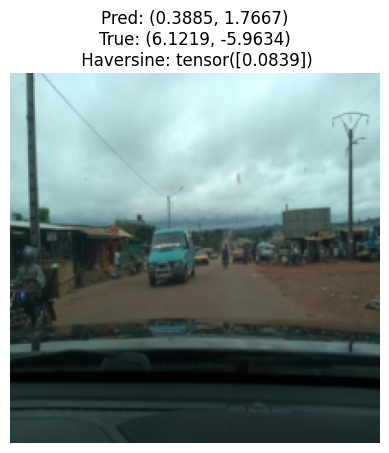

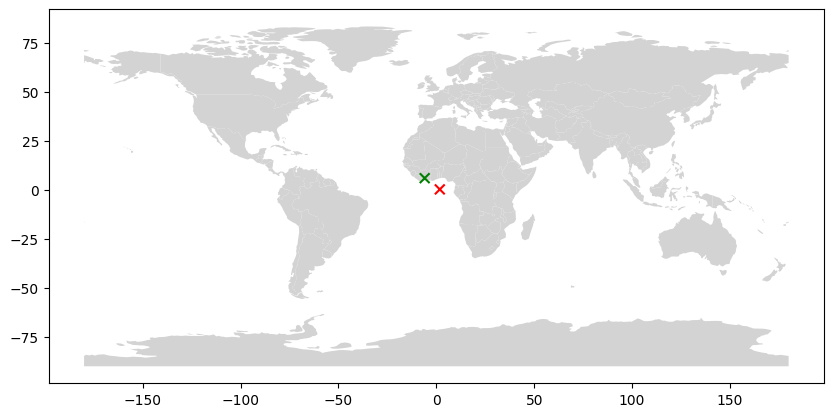

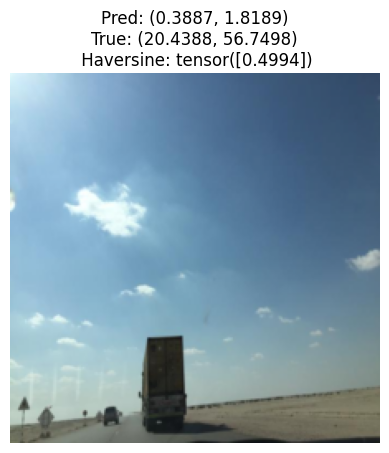

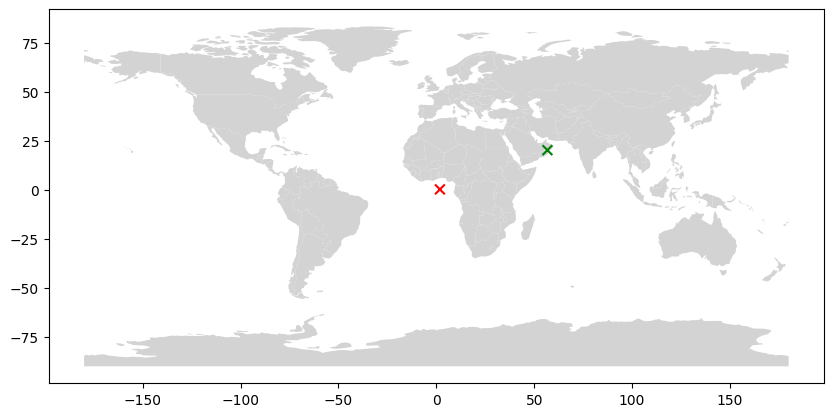

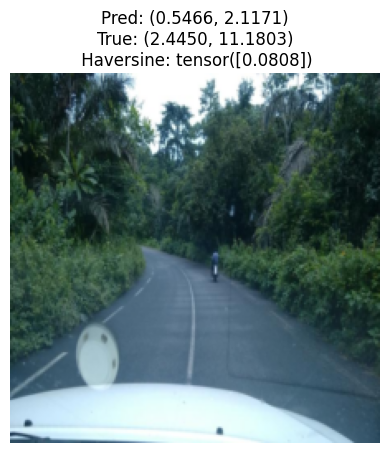

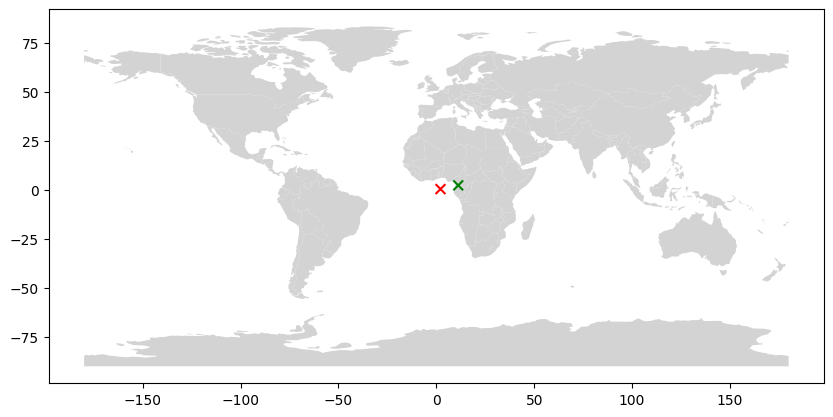

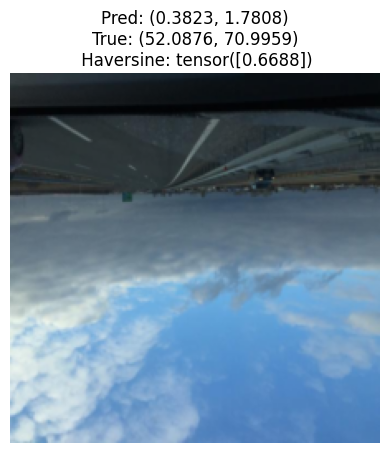

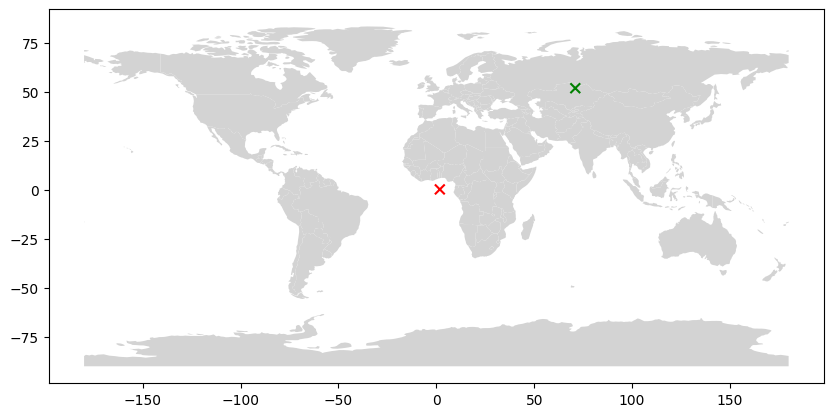

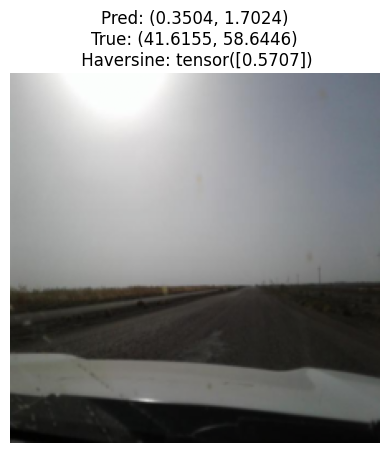

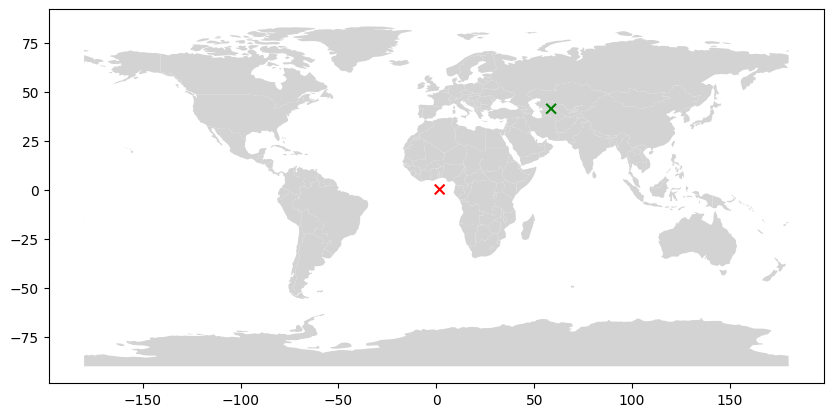

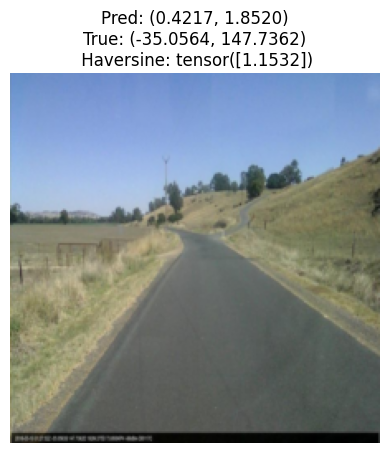

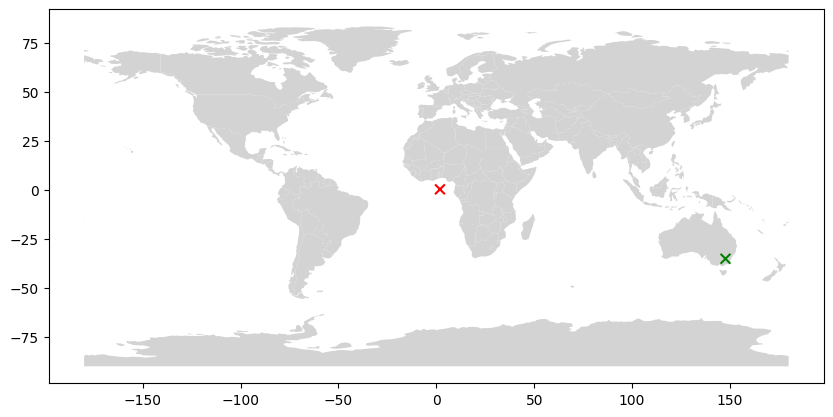

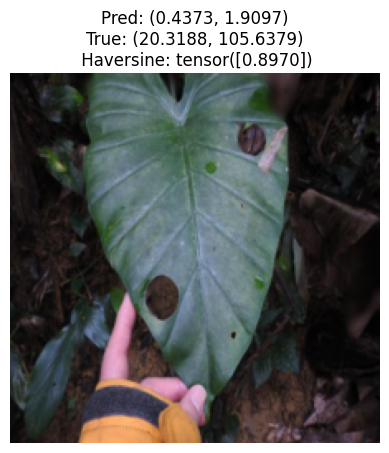

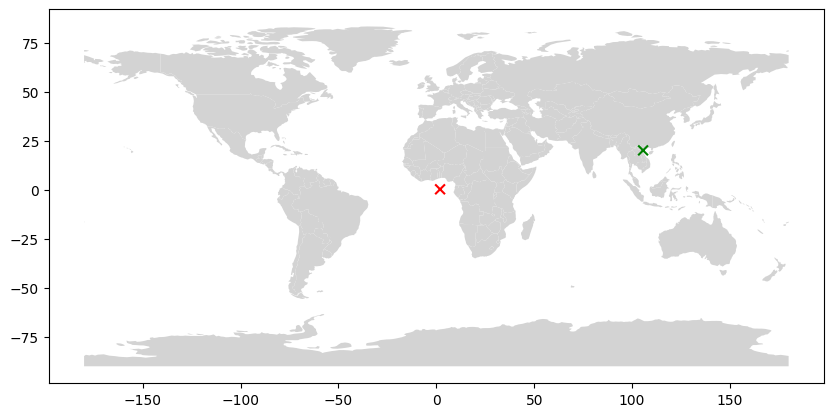

In [32]:
plot_predictions(model, val_dataloader, num_samples=10)